<a href="https://colab.research.google.com/github/vikramwakhlu/Time_Series_Modelling/blob/main/Time_Series_W2_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
# STEP 0: Install gdown
!pip install -U gdown
!pip install darts
# STEP 1: Imports and helper functions
import pandas as pd
import requests
import io
import gdown
import matplotlib.pyplot as plt


In [89]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_train = pd.read_csv("/content/drive/MyDrive/time series modelling/guayas_prepared.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
# Step 2: Clamp to Jan 1 – Mar 31, 2014
df_train['date'] = pd.to_datetime(df_train['date'])
df_window = df_train[
    (df_train['date'] >= "2014-01-01") &
    (df_train['date'] <= "2014-03-31")
].copy()

In [91]:
print(df_window.head())

          date  id  store_nbr  item_nbr  unit_sales onpromotion  year  month  \
339 2014-01-01   0         24     96995         0.0           0  2014      1   
340 2014-01-02   0         24     96995         0.0           0  2014      1   
341 2014-01-03   0         24     96995         0.0           0  2014      1   
342 2014-01-04   0         24     96995         0.0           0  2014      1   
343 2014-01-05   0         24     96995         0.0           0  2014      1   

     day  day_of_week  unit_sales_7d_avg  
339    1            2           1.142857  
340    2            3           1.142857  
341    3            4           1.142857  
342    4            5           0.714286  
343    5            6           0.714286  


In [92]:
print(df_window.head())
print(df_window.columns)
print(df_window.index)


          date  id  store_nbr  item_nbr  unit_sales onpromotion  year  month  \
339 2014-01-01   0         24     96995         0.0           0  2014      1   
340 2014-01-02   0         24     96995         0.0           0  2014      1   
341 2014-01-03   0         24     96995         0.0           0  2014      1   
342 2014-01-04   0         24     96995         0.0           0  2014      1   
343 2014-01-05   0         24     96995         0.0           0  2014      1   

     day  day_of_week  unit_sales_7d_avg  
339    1            2           1.142857  
340    2            3           1.142857  
341    3            4           1.142857  
342    4            5           0.714286  
343    5            6           0.714286  
Index(['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg'],
      dtype='object')
Index([     339,      340,      341,      342,      343,      344,      345,
            346,   

In [93]:
# 1) Daily aggregation (sum across items/stores/families)
daily = (
    df_window
    .groupby('date', as_index=False)['unit_sales']
    .sum()
    .sort_values('date')
    .copy()
)


In [94]:
# Complete daily calendar and fill gaps with 0 sales
full_idx = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')
daily = (
    daily.set_index('date')
         .reindex(full_idx)
         .rename_axis('date')
         .fillna({'unit_sales': 0})
         .reset_index()
)

# sanity check
print(daily.columns.tolist())
print(daily.head())


['date', 'unit_sales']
        date  unit_sales
0 2014-01-01     107.000
1 2014-01-02    4909.000
2 2014-01-03    3705.975
3 2014-01-04    5606.000
4 2014-01-05    7092.738


In [95]:
# Save back
out_path = "/content/drive/MyDrive/time series modelling/guayas_top3_janmar2014.csv"
df_window.to_csv(out_path, index=False)
print("✅ Saved to:", out_path)

✅ Saved to: /content/drive/MyDrive/time series modelling/guayas_top3_janmar2014.csv


Features: Lag

In [96]:
# Create lag features (e.g., sales from the previous day, previous week)
daily['lag_1'] = daily['unit_sales'].shift(1)
daily['lag_7'] = daily['unit_sales'].shift(7)
daily['lag_14'] = daily['unit_sales'].shift(14)
daily['lag_28'] = daily['unit_sales'].shift(28)
daily['lag_30'] = daily['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
daily.dropna(inplace=True)

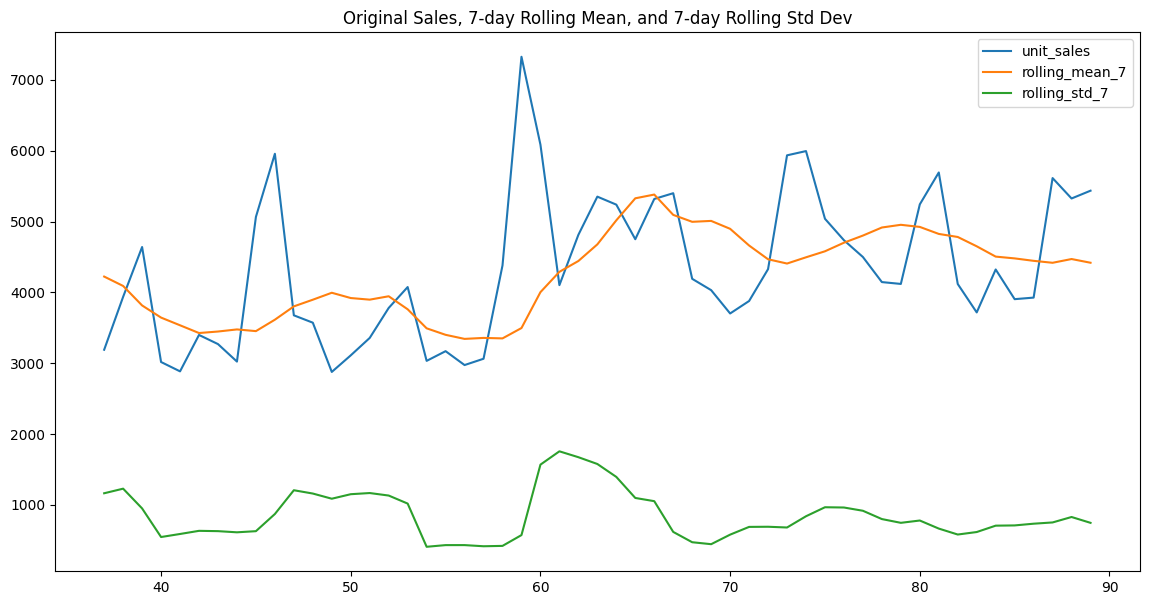

In [97]:
# Create rolling mean and rolling standard deviation features.
# We need to shift by one before rolling so only past data are used.
daily['rolling_mean_7'] = daily['unit_sales'].shift(1).rolling(window=7).mean()
daily['rolling_std_7'] = daily['unit_sales'].shift(1).rolling(window=7).std()

# Drop any NaN values after creating rolling features
daily.dropna(inplace=True)

# Visualize the new features alongside the original sales
daily[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

In [98]:
# Add date-based features
daily = daily.set_index('date').sort_index()   # when date is index, sort by index
daily['day_of_week'] = daily.index.dayofweek
daily['month'] = daily.index.month
daily['is_weekend'] = (daily['day_of_week'] >= 5).astype(int)
#daily['day_of_month'] = daily.index.day
#daily['month_end']    = daily.index.is_month_end.astype(int)
#daily['is_payday']    = np.isin(daily.index.day, [1, 15]).astype(int)

# Bring 'date' BACK as a real column (do NOT drop=True)
daily = daily.reset_index()                    # now 'date' is a column again

# Optional: keep rows ordered and simple index
daily = daily.sort_values('date').reset_index(drop=True)

In [101]:
# Choose from what we already have
feature_cols = [
    'lag_1','lag_7','lag_14','lag_30',
    'rolling_mean_7','rolling_std_7',
    'day_of_week','month','is_weekend'
]
target_col = 'unit_sales'

In [102]:
# Build modeling frame and drop NaNs coming from lags/rolling
df_ml = daily[['date', target_col] + feature_cols].copy()
df_ml = df_ml.dropna(subset=[target_col] + feature_cols).reset_index(drop=True)

display(df_ml.head())
df_ml.info()

,date,unit_sales,lag_1,lag_7,lag_14,lag_30,rolling_mean_7,rolling_std_7,day_of_week,month,is_weekend
0,2014-02-07,3190.0,3063.0,4117.0,3916.0,4256.496,4222.857143,1164.409640,4,2,0
1,2014-02-08,3937.0,3190.0,5863.0,4921.0,4680.000,4090.428571,1229.357943,5,2,1
2,2014-02-09,4640.0,3937.0,5840.0,6041.0,3852.694,3815.285714,950.397411,6,2,1
3,2014-02-10,3017.0,4640.0,3777.0,3566.0,5318.000,3643.857143,546.885554,0,2,0
4,2014-02-11,2885.0,3017.0,3650.0,3742.0,5814.124,3535.285714,589.803841,1,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            53 non-null     datetime64[ns]
 1   unit_sales      53 non-null     float64       
 2   lag_1           53 non-null     float64       
 3   lag_7           53 non-null     float64       
 4   lag_14          53 non-null     float64       
 5   lag_30          53 non-null     float64       
 6   rolling_mean_7  53 non-null     float64       
 7   rolling_std_7   53 non-null     float64       
 8   day_of_week     53 non-null     int32         
 9   month           53 non-null     int32         
 10  is_weekend      53 non-null     int64         
dtypes: datetime64[ns](1), float64(7), int32(2), int64(1)
memory usage: 4.3 KB


In [103]:
# Chronological split: Train = Jan–Feb 2014, Test = Mar 2014
train_mask = (df_ml['date'] >= pd.Timestamp('2014-01-01')) & (df_ml['date'] <= pd.Timestamp('2014-02-28'))
test_mask  = (df_ml['date'] >= pd.Timestamp('2014-03-01')) & (df_ml['date'] <= pd.Timestamp('2014-03-31'))



In [104]:
train_df = df_ml.loc[train_mask].copy()
test_df  = df_ml.loc[test_mask].copy()

In [105]:
print("Features used:", feature_cols)
print("Train:", train_df['date'].min().date(), "→", train_df['date'].max().date(), "| n =", len(train_df))
print("Test :", test_df['date'].min().date(),  "→", test_df['date'].max().date(),  "| n =", len(test_df))


Features used: ['lag_1', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7', 'day_of_week', 'month', 'is_weekend']
Train: 2014-02-07 → 2014-02-28 | n = 22
Test : 2014-03-01 → 2014-03-31 | n = 31


In [106]:
# Split X/y
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test  = test_df[feature_cols]
y_test  = test_df[target_col]


In [109]:
# Fit XGBoost
!pip -q install xgboost
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=900,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=900,
             n_jobs=-1, num_parallel_tree=None, ...)

In [110]:
# Predict & evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

# Robust RMSE that works on old/new sklearn
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # newer sklearn
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))        # older sklearn

print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

MAE : 1,059.31
RMSE: 1,205.48


In [111]:
print("Train mask head:\n", train_mask.head())
print("\nTest mask head:\n", test_mask.head())
print("\ndf_ml head:\n", df_ml.head())
print("\ndf_ml info:\n", df_ml.info())

Train mask head:
 0    True
1    True
2    True
3    True
4    True
Name: date, dtype: bool

Test mask head:
 0    False
1    False
2    False
3    False
4    False
Name: date, dtype: bool

df_ml head:
         date  unit_sales   lag_1   lag_7  lag_14    lag_30  rolling_mean_7  \
0 2014-02-07      3190.0  3063.0  4117.0  3916.0  4256.496     4222.857143   
1 2014-02-08      3937.0  3190.0  5863.0  4921.0  4680.000     4090.428571   
2 2014-02-09      4640.0  3937.0  5840.0  6041.0  3852.694     3815.285714   
3 2014-02-10      3017.0  4640.0  3777.0  3566.0  5318.000     3643.857143   
4 2014-02-11      2885.0  3017.0  3650.0  3742.0  5814.124     3535.285714   

   rolling_std_7  day_of_week  month  is_weekend  
0    1164.409640            4      2           0  
1    1229.357943            5      2           1  
2     950.397411            6      2           1  
3     546.885554            0      2           0  
4     589.803841            1      2           0  
<class 'pandas.core.fr

MAE : 1,059.31
RMSE: 1,205.48


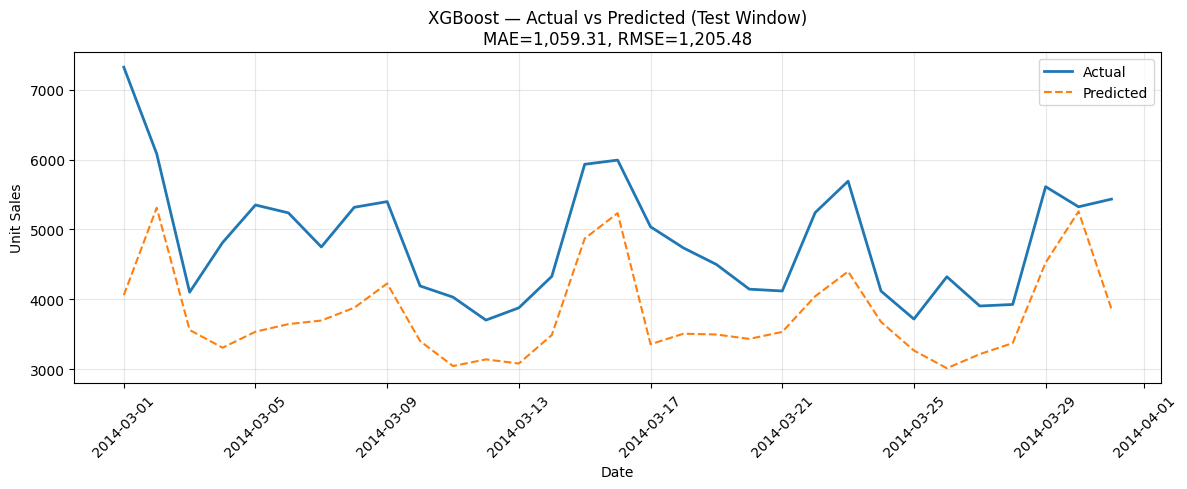

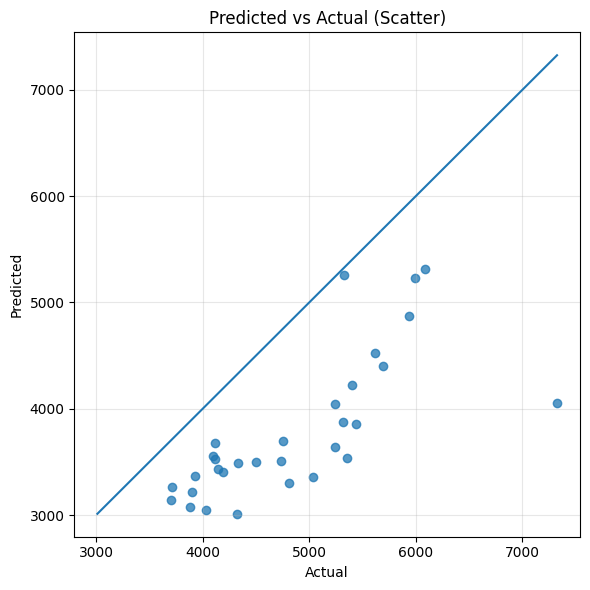

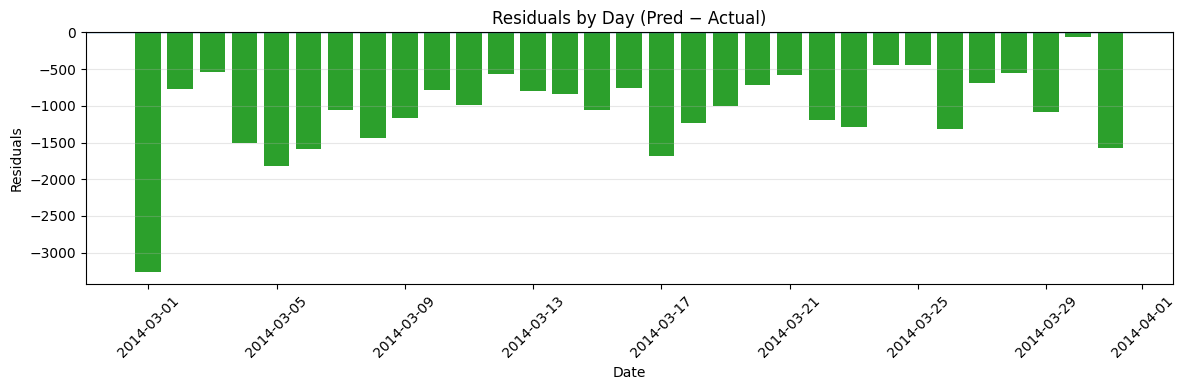

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Metrics ---
mae = mean_absolute_error(y_test, y_pred)
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

# --- Build evaluation frame ---
eval_df = test_df[['date']].copy()
eval_df['actual'] = y_test.values
eval_df['pred']   = y_pred
eval_df['resid']  = eval_df['pred'] - eval_df['actual']   # >0 = over-forecast, <0 = under-forecast
eval_df.head()

# --- 1) Time plot: Actual vs Predicted ---
plt.figure(figsize=(12,5))
plt.plot(eval_df['date'], eval_df['actual'], label='Actual', linewidth=2)
plt.plot(eval_df['date'], eval_df['pred'],   label='Predicted', linestyle='--')
plt.title(f'XGBoost — Actual vs Predicted (Test Window)\nMAE={mae:,.2f}, RMSE={rmse:,.2f}')
plt.xlabel('Date'); plt.ylabel('Unit Sales'); plt.grid(True, alpha=0.3); plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2) Scatter: Predicted vs Actual (y=x line) ---
plt.figure(figsize=(6,6))
plt.scatter(eval_df['actual'], eval_df['pred'], alpha=0.75)
lims = [min(eval_df['actual'].min(), eval_df['pred'].min()),
        max(eval_df['actual'].max(), eval_df['pred'].max())]
plt.plot(lims, lims)  # 45° line
plt.title('Predicted vs Actual (Scatter)')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 3) Residuals by day: over/under-forecast ---
plt.figure(figsize=(12,4))
colors = np.where(eval_df['resid'] >= 0, 'tab:red', 'tab:green')  # red = over, green = under
plt.bar(eval_df['date'], eval_df['resid'], width=0.8, align='center', color=colors)
plt.axhline(0, linewidth=1)
plt.title('Residuals by Day (Pred − Actual)')
plt.xlabel('Date'); plt.ylabel('Residuals'); plt.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()